In [1]:
import gurobipy as gb
import networkx as nx

import pygraphviz as pygv


import os
from IPython.display import SVG, display


#
# Drawing 
# functions
#

#
# Drawing 
# functions
#

def DrawInitialGraph():
    global DrawG
    DrawG = pygv.AGraph(directed='true',strict='true', splines='true')


    for i in G.nodes():
        pos = str(G.node[i]['x'] * args.scale) + ',' + str((G.node[i]['y'])* args.scale)
        if i == root:
            DrawG.add_node (i, shape='circle', pos=pos, color="red", fontsize='8', width='0.3', fixedsize='true')
        else:
            DrawG.add_node (i, shape='circle', pos=pos, color="black", fontsize='8', width='0.3', fixedsize='true')   	

    DrawG.layout(prog='neato', args='-n')
    DrawG.draw (path=str(basename) + '.svg', format='svg')
    DrawG.clear()


def DrawSol (x):

    for i in G.nodes():
        pos = str(G.node[i]['x'] * args.scale) + ',' + str((G.node[i]['y'])* args.scale)
        DrawG.add_node (i, shape='circle', pos=pos,fontsize='8', width='0.3', fixedsize='true')

    DrawG.layout(prog='neato', args='-n')
    filepath=str(basename) + '_sol.svg'

    for i in G.edges():
        h = i[0]
        k = i[1]
        if x[i].x > 0.00001:
            lab = round(x[i].x,4)	
            if x[i].x > 0.999999:
                DrawG.add_edge(h, k, color='black', label=lab, fontsize='8')
            else:
                DrawG.add_edge(h, k, color='red', label=lab, fontsize='8')

    DrawG.draw (path=filepath, format='svg')
    DrawG.clear()

def DrawSubtour (x, subtour):
    for i in G.nodes():
        pos = str(G.node[i]['x'] * args.scale) + ',' + str((G.node[i]['y'])* args.scale)
        if i in subtour:
            DrawG.add_node (i, shape='circle', pos=pos, fontsize='8', width='0.3', fixedsize='true', style='filled')
        else:
            DrawG.add_node (i, shape='circle', pos=pos, fontsize='8', width='0.3', fixedsize='true')

    DrawG.layout(prog='neato', args='-n')
    filepath=str(basename) + '_sub.svg'

    for i in G.edges():
        h = i[0]
        k = i[1]
        if x[i].x > 0.00001:
            lab = round(x[i].x,4)	
            if x[i].x > 0.999999:
                DrawG.add_edge(h, k, color='black', label=lab, fontsize='8')
            else:
                DrawG.add_edge(h, k, color='red', label=lab, fontsize='8')

    DrawG.draw (path=filepath, format='svg')
    DrawG.clear()

    
class args:
    filename = None
    scale = 20

## mTSP

>**Given**
>A directed graph $G=(N,A)\;$ and a cost $c_{ij} > 0$ for each arc in $A$
>
>**Find**
> A set of routes for $m$ salesmen who all start from and turn back to a home city (depot) 
 


### Formulation

Decision variables:
$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is in the tour} \\
0 \text{ otherwise}
\end{cases}
$$

Formulation:
$$
\begin{alignat}{3}
& \min \sum_{(i,j) \in A} x_{ij} &\\
\text{s.t.} \;\;\;\;\;&\\
\sum_{j = 2}^{j=n} x_{1j} &= m  \;\; \text{(OUT-R)}\\
\sum_{i = 2}^{i=n} x_{i1} &= m \;\; \text{(IN-R)}\\
\sum_{j \in \delta^+(i)} x_{ij} &= 1 \;\; \forall i \in N, i\not=1 \;\; \text{(FS)}\\
\sum_{j \in \delta^-(i)} x_{ji} &= 1 \;\; \forall i \in N, i\not=1 \;\; \text{(RS)}\\
\sum_{(i,j) \in A(S)} x_{ij} &\le |S| - 1 \;\; \forall S \subset N, |S| \ge 2 \;\; \text{(SEC)}\\
x & \in \{0,1\}^{|A|}
\end{alignat}
$$

In [2]:
# 
# Read the graph in the graphML format
#


args.filename = 'atsp18072017.gml'

basename = os.path.splitext(args.filename)[0]

G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

print(G.is_directed())

#print(G.edges(data=True))

G has 30 nodes and 870 edges
True


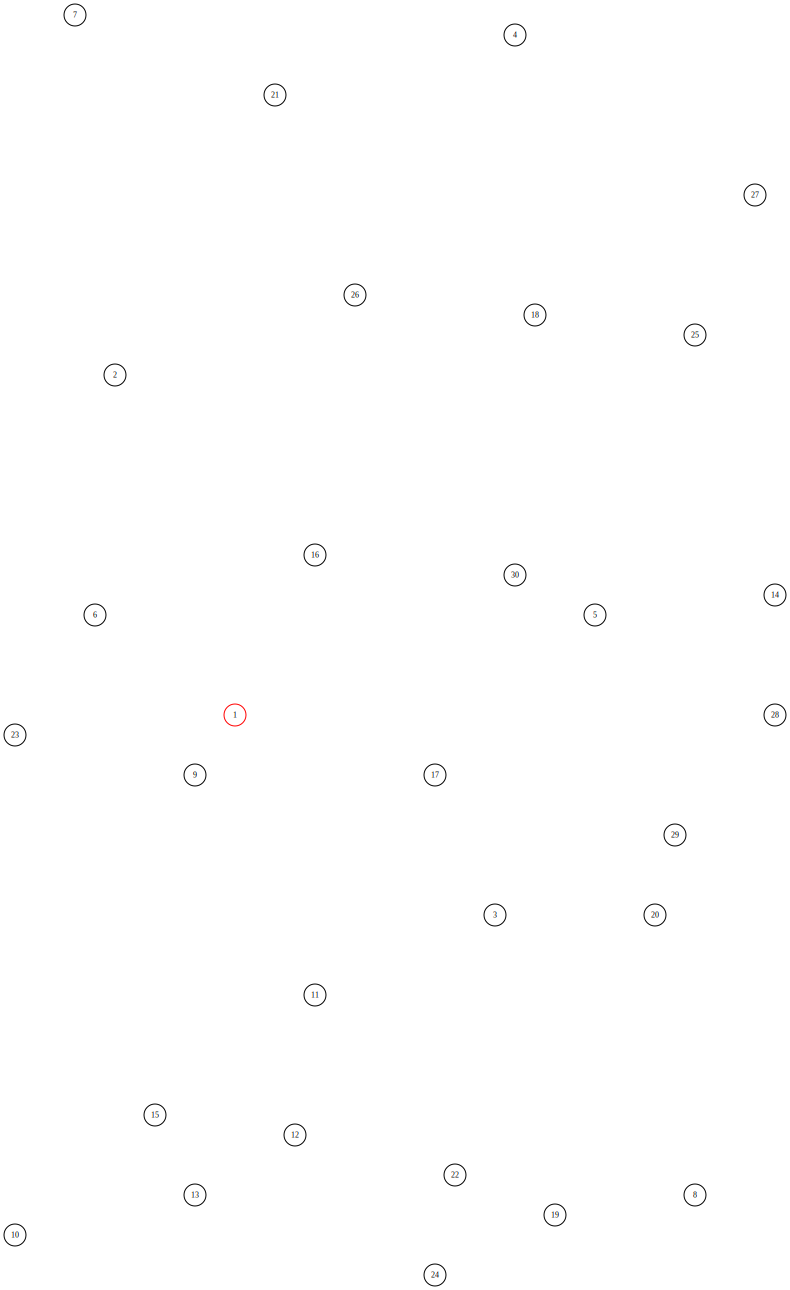

In [3]:
root = list(G.nodes())[0]

DrawInitialGraph()

display(SVG(filename=basename+'.svg'))

## mTSP: Branch-and-cut

In [4]:
m = 3

In [5]:
mtsp = gb.Model()

x = mtsp.addVars(G.edges(),\
                 obj=[G[i][j]['dist']\
                      for i,j in G.edges()],\
             vtype=gb.GRB.BINARY, name='x')

mtsp.write('mtsp.lp')

In [6]:
mtsp.addConstr(x.sum(root,'*') == m, name = 'OUT-R')
mtsp.addConstr(x.sum('*',root) == m, name = 'IN-R')

<gurobi.Constr *Awaiting Model Update*>

In [7]:
mtsp.addConstrs((x.sum(i,'*') == 1 \
                 for i in G.nodes() if i != root), name='FS')

mtsp.update()
mtsp.write('mtsp.lp')

In [8]:
mtsp.addConstrs((x.sum('*',i) == 1 \
                 for i in G.nodes() if i != root), name='RS')

mtsp.update()
mtsp.write('mtsp.lp')

In [9]:
mtsp.addConstrs((x[i,j] + x[j,i] <= 1 \
                 for i,j in G.edges() if j > i and i != root and j != root ), name='SUB2')

mtsp.update()
mtsp.write('atsp.lp')

In [10]:

mtsp._graph = G
mtsp._vars = x



In [11]:
def SECcallback (model, where):

        
    if where == gb.GRB.Callback.MIPSOL:
        
        x = model._vars
        xrel = model.cbGetSolution(x)
        G = model._graph
                        
        for i,j in G.edges():
            G[i][j]['capacity'] = xrel[i,j]
        
        for i in list(G.nodes())[1:]:
                cut_val, cut = nx.minimum_cut(G,1,i)

                if cut_val < 0.99999:

                    subtouredges = [(u,v) for u in cut[0] for v in cut[1] if G.has_edge(u,v)]

                    model.cbLazy(gb.quicksum(x[i,j] for i,j in subtouredges) >= 1)
                    break
                

In [12]:
mtsp.reset()
mtsp.Params.lazyConstraints = 1
mtsp.optimize(SECcallback)

Changed value of parameter lazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Optimize a model with 466 rows, 870 columns and 2552 nonzeros
Variable types: 0 continuous, 870 integer (870 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+02, 7e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve time: 0.01s
Presolved: 466 rows, 870 columns, 2552 nonzeros
Variable types: 0 continuous, 870 integer (870 binary)

Root relaxation: objective 3.030700e+04, 82 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 31034.0000    0   10          - 31034.0000      -     -    0s
H    0     0                    72101.000000 31034.0000  57.0%     -    0s
H    0     0                    31934.000000 31034.0000  2.82%     -    0s
     0     0 31421.4444    0   56 31934.0000 31421.4444  1.61%   

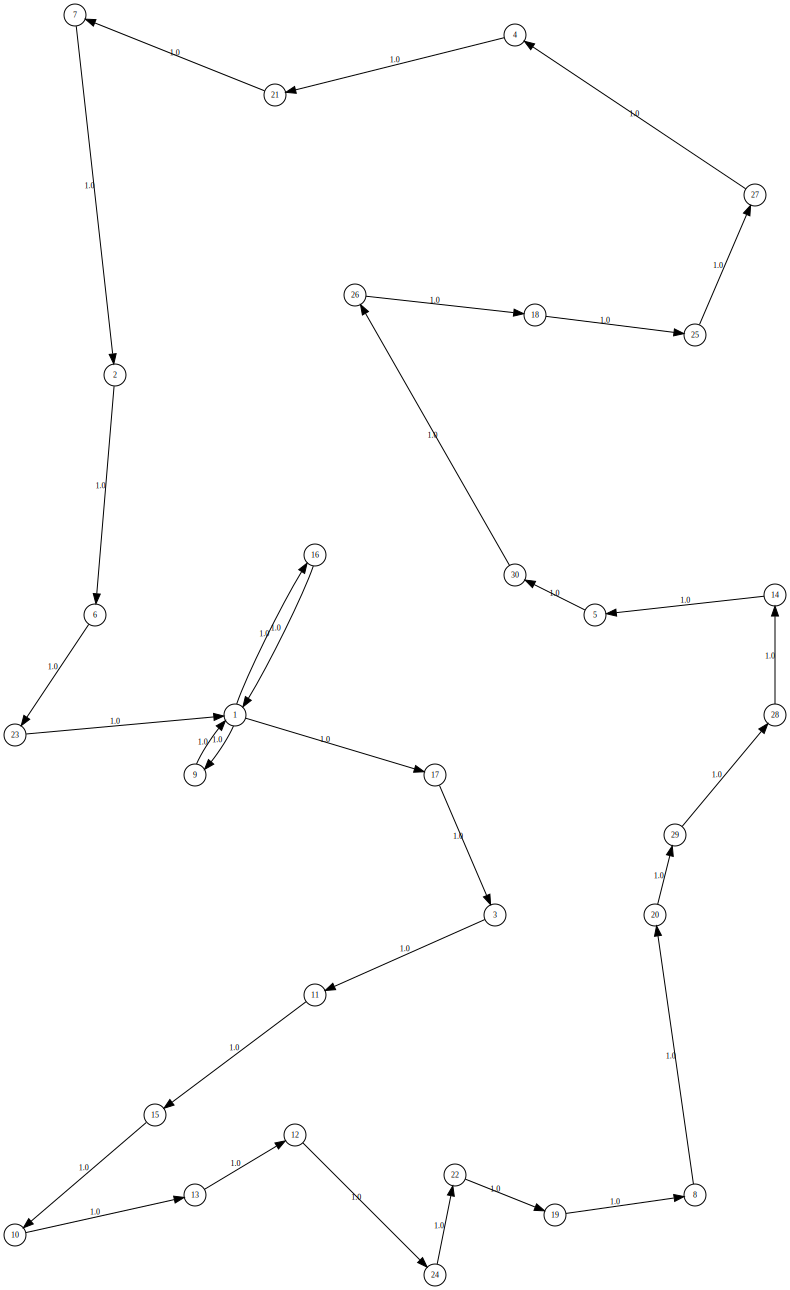

In [13]:
DrawSol(x)

display(SVG(filename=basename+'_sol.svg'))

## mTSP MTZ constraints

### Formulation

Decision variables:
$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is in the tour} \\
0 \text{ otherwise}
\end{cases}
$$

Formulation:
$$
\begin{alignat}{3}
& \min \sum_{(i,j) \in A} x_{ij} &\\
\text{s.t.} \;\;\;\;\;&\\
\sum_{j = 2}^{j=n} x_{1j} &= m  \;\; \text{(OUT-R)}\\
\sum_{i = 2}^{i=n} x_{i1} &= m \;\; \text{(IN-R)}\\
\sum_{j \in \delta^+(i)} x_{ij} &= 1 \;\; \forall i \in N, i\not=1 \;\; \text{(FS)}\\
\sum_{j \in \delta^-(i)} x_{ji} &= 1 \;\; \forall i \in N, i\not=1 \;\; \text{(RS)}\\
u_i - u_j + p x_{ij} &\le p-1 \;\; \forall (i,j) \in A, i,j \not = 1\\
x & \in \{0,1\}^{|A|}
\end{alignat}
$$

In [39]:
m = 3

p = 11

In [40]:
mtsp_mtz = gb.Model()

x = mtsp_mtz.addVars(G.edges(),\
                 obj=[G[i][j]['dist']\
                      for i,j in G.edges()],\
             vtype=gb.GRB.BINARY, name='x')

u = mtsp_mtz.addVars(G.nodes(), obj=0.0, vtype=gb.GRB.CONTINUOUS,\
                     lb=2.0, ub=p, name='u')

mtsp_mtz.write('mtsp_mtz.lp')

In [41]:
mtsp_mtz.addConstr(x.sum(root,'*') == m, name = 'OUT-R')
mtsp_mtz.addConstr(x.sum('*',root) == m, name = 'IN-R')
mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')

In [42]:
mtsp_mtz.addConstrs((x.sum(i,'*') == 1 \
                 for i in G.nodes() if i != root), name='FS')

mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')

In [43]:
mtsp_mtz.addConstrs((x.sum('*',i) == 1 \
                 for i in G.nodes() if i != root), name='RS')

mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')

In [44]:
mtsp_mtz.addConstrs((x[i,j] + x[j,i] <= 1 \
                 for i,j in G.edges() if j > i \
                     and i != root and j != root ), name='SUB2')

mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')

In [45]:
u[root].lb = 1
u[root].ub = 1

mtsp_mtz.addConstrs((u[i] - u[j] + p * x[i,j] <= p - 1 \
                     for i in G.nodes() for j in G.nodes()\
                    if i != j and i != root and j != root and G.has_edge(i,j)), name='MTZ')

mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')


mtsp_mtz._graph = G
mtsp_mtz._vars = x


In [46]:

mtsp_mtz.optimize()

Optimize a model with 1278 rows, 900 columns and 4988 nonzeros
Variable types: 30 continuous, 870 integer (870 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e+02, 7e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+01]
Presolve removed 0 rows and 1 columns
Presolve time: 0.01s
Presolved: 1278 rows, 899 columns, 4988 nonzeros
Variable types: 29 continuous, 870 integer (870 binary)

Root relaxation: objective 3.034607e+04, 140 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 30346.0692    0   45          - 30346.0692      -     -    0s
     0     0 30359.3083    0   45          - 30359.3083      -     -    0s
     0     0 30361.6439    0   52          - 30361.6439      -     -    0s
     0     0 30586.2250    0   55          - 30586.2250      -     -    0s
H    0     0                    42

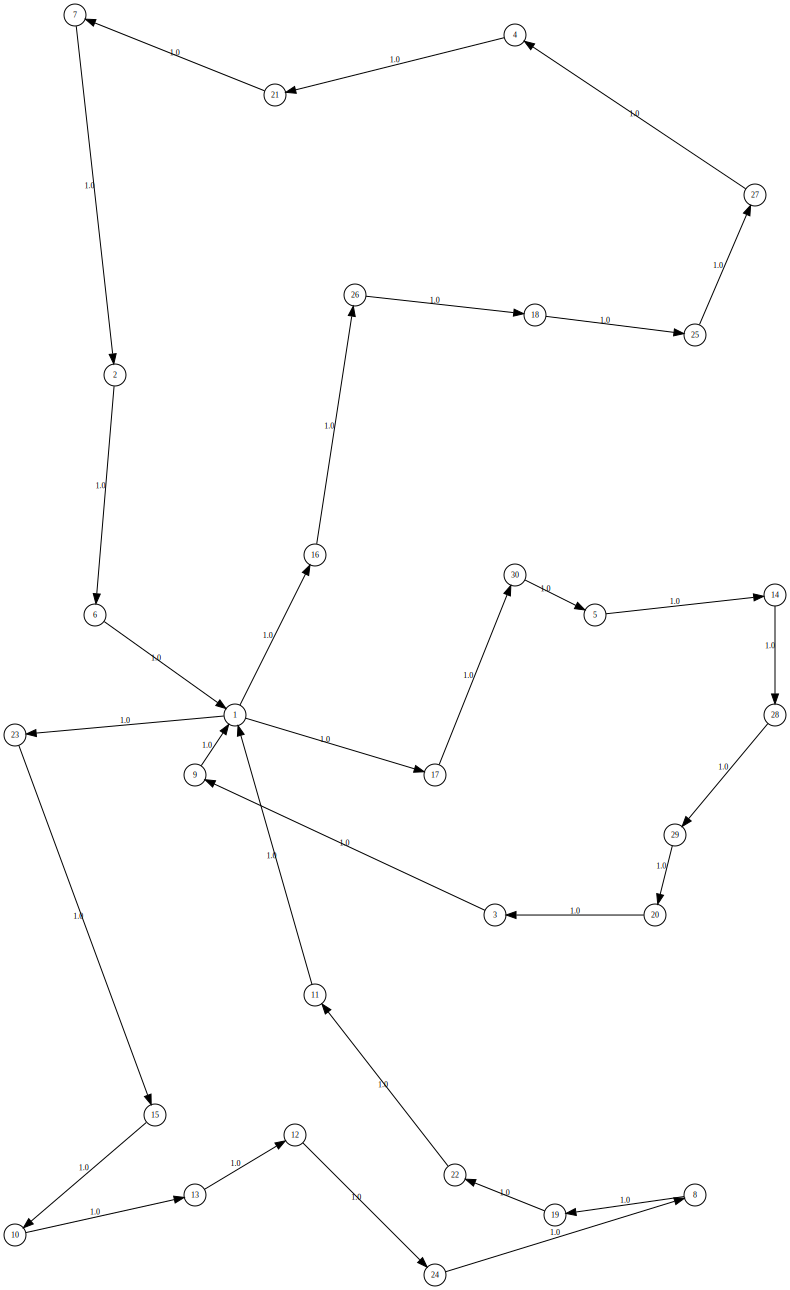

In [38]:
DrawSol(x)

display(SVG(filename=basename+'_sol.svg'))

In [49]:
def SECcallback (model, where):

        
    if where == gb.GRB.Callback.MIPNODE:
        status = model.cbGet(gb.GRB.Callback.MIPNODE_STATUS)
        if status == gb.GRB.OPTIMAL:
            x = model._vars
            xrel = model.cbGetNodeRel(x) 
            G = model._graph
                        
            for i,j in G.edges():
                G[i][j]['capacity'] = xrel[i,j]

            for i in list(G.nodes())[1:]:
                cut_val, cut = nx.minimum_cut(G,1,i)

                if cut_val < 0.99999:

                    subtouredges = [(u,v) for u in cut[0] for v in cut[1] if G.has_edge(u,v)]

                    model.cbCut(gb.quicksum(x[i,j] for i,j in subtouredges) >= 1)
                    break

In [50]:
mtsp_mtz.reset()
mtsp_mtz.optimize(SECcallback)
mtsp_mtz.Params.PreCrush = 1

Optimize a model with 3628 rows, 2500 columns and 14308 nonzeros
Variable types: 50 continuous, 2450 integer (2450 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+02, 8e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+01]
Presolve removed 0 rows and 1 columns
Presolve time: 0.03s
Presolved: 3628 rows, 2499 columns, 14308 nonzeros
Variable types: 49 continuous, 2450 integer (2450 binary)
Found heuristic solution: objective 152828.00000

Root relaxation: objective 3.515950e+04, 194 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 35159.5000    0   78 152828.000 35159.5000  77.0%     -    0s
     0     0 35753.9333    0   92 152828.000 35753.9333  76.6%     -    0s
H    0     0                    62598.000000 35753.9333  42.9%     -    0s
     0     0 36114.2404    0   91 62598.0000 36114.2

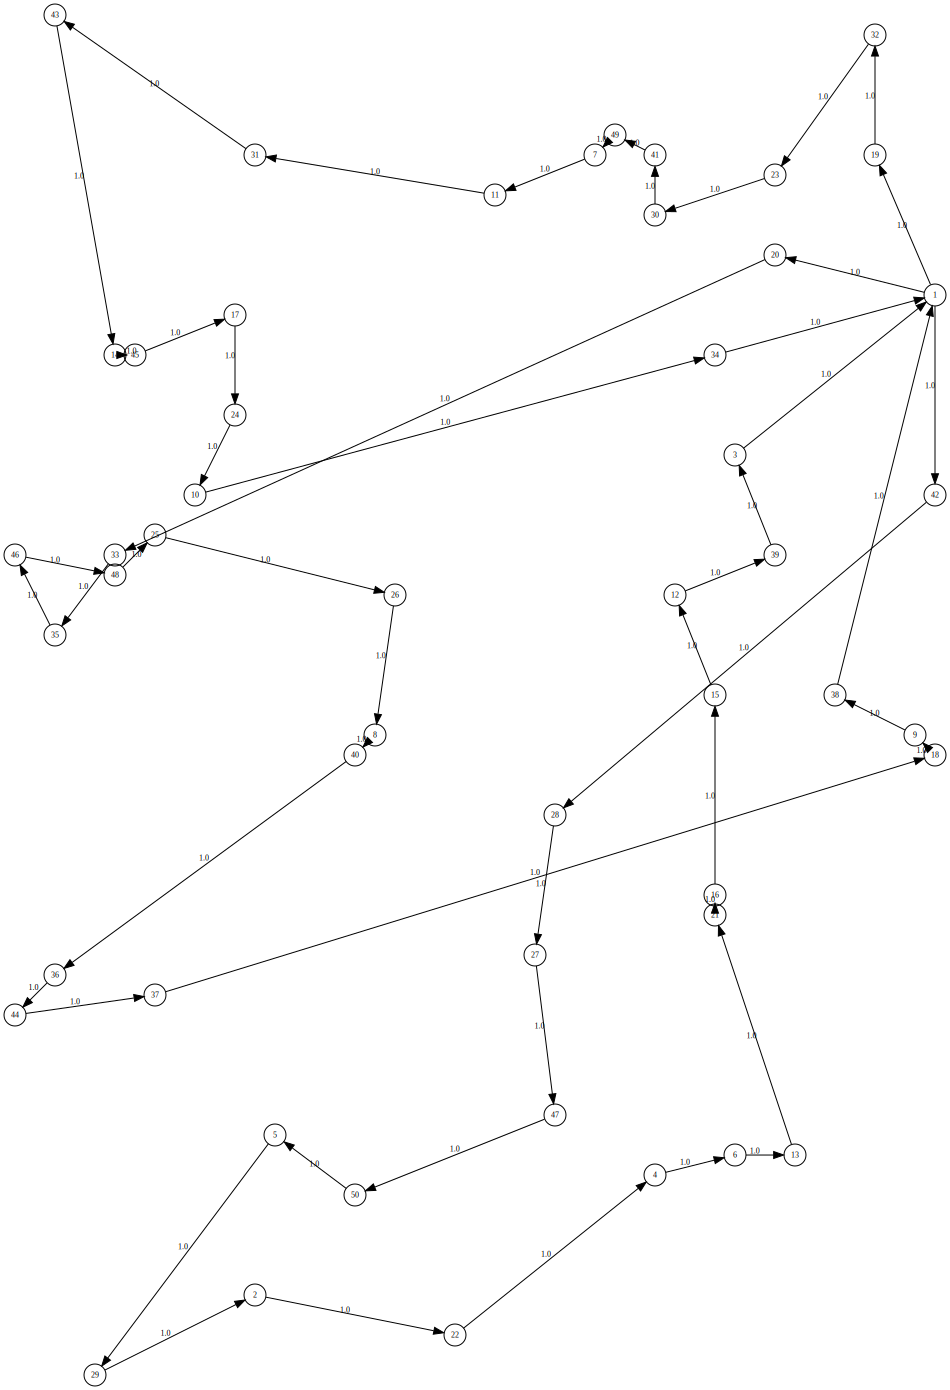

In [51]:
DrawSol(x)

display(SVG(filename=basename+'_sol.svg'))